In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
import torchvision.transforms as trns
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 10]

In [ ]:
file_map = dict()
for i in range(4):
    path = '/content/drive/MyDrive/images_' + ('00' if i < 9 else '0') + str(i + 1) + '/images/'
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)) and f[-4:] == '.png':
            file_map[f] = os.path.join(path, f)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000011_006.png,Atelectasis,6,11,75,M,PA,2992,2991,0.143,0.143
1,00000086_002.png,Atelectasis,1,86,62,M,PA,2500,2048,0.171,0.171
2,00000119_001.png,Atelectasis,0,119,56,M,AP,2500,2048,0.168,0.168
3,00000120_000.png,Atelectasis,0,120,81,F,PA,2894,2821,0.143,0.143
4,00000143_008.png,Atelectasis,5,143,91,M,AP,2500,2048,0.168,0.168
5,00000143_009.png,Atelectasis,6,143,91,M,PA,2992,2991,0.143,0.143
6,00000143_011.png,Atelectasis,8,143,91,M,PA,2992,2991,0.143,0.143
7,00000147_001.png,Atelectasis,1,147,66,F,PA,2742,2948,0.143,0.143
8,00000149_002.png,Atelectasis,2,149,70,M,PA,2770,2849,0.143,0.143
9,00000149_005.png,Atelectasis,5,149,70,M,AP,2500,2048,0.168,0.168


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  1600 non-null   object 
 1   Finding Labels               1600 non-null   object 
 2   Follow-up #                  1600 non-null   int64  
 3   Patient ID                   1600 non-null   int64  
 4   Patient Age                  1600 non-null   int64  
 5   Patient Gender               1600 non-null   object 
 6   View Position                1600 non-null   object 
 7   OriginalImage[Width          1600 non-null   int64  
 8   Height]                      1600 non-null   int64  
 9   OriginalImagePixelSpacing[x  1600 non-null   float64
 10  y]                           1600 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 137.6+ KB


In [ ]:
def showImage(pil):

    plt.imshow(np.array(pil) / 255)

In [ ]:
def loadImage(path):
    return Image.open(path).convert('RGB')

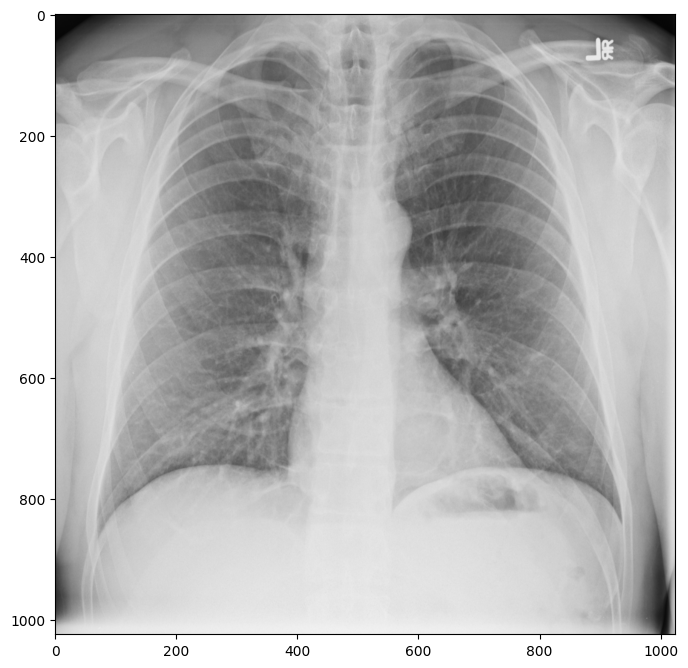

In [ ]:
showImage(loadImage(file_map[list(file_map.keys())[100]]))

In [ ]:
classes=[
    'Atelectasis',
    'Consolidation',
    'Mass',
    'Pneumothorax',
    'Fibrosis',
    'Infiltration',
    'Emphysema',
    'No Finding'
]

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data, transforms):
        self.image_paths = [file_map[f] for f in data[0]]
        self.labels = data[1]
        self.transforms = transforms

    def __len__(self):
        return len(data[0])

    def __getitem__(self, idx):
        image = self.transforms(loadImage(self.image_paths[idx]))
        target = torch.tensor([int(cls in self.labels[idx]) for cls in classes], dtype=torch.float32)
        return (image, target)

In [ ]:
data = (df.iloc[:1600, 0], [df.iloc[i, 1].split('|') for i in range(1600)])

In [ ]:
dataset = ImageDataset(data, trns.Compose([
    trns.Resize((240, 240)),
    trns.ToTensor(),
    trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],inplace=True)
]))

In [ ]:
train_dataset, validation_dataset = random_split(dataset, [int(len(dataset) * 0.85),
            len(dataset) - int(len(dataset) * 0.85)])

In [ ]:
train_dataset_size = len(train_dataset)
validation_dataset_size = len(validation_dataset)

train_dataset_size, validation_dataset_size

(1360, 240)

In [ ]:
num_classes = 8
input_shape = (3, 240, 240)

In [ ]:
num_clients = 1
rounds = 1
batch_size = 64
epochs_per_client = 5
learning_rate = 1e-1

In [ ]:
resnet34 = models.resnet34(pretrained=True)
resnet34

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 195MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [ ]:
class CenteralisedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        self.network.fc = torch.nn.Linear(self.network.fc.in_features, num_classes)
        self.track_layers = {
            'layer4':  self.network.layer4,
            'linear': self.network.fc
        }
        self.freeze()

    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad = False
        for layer_name in self.track_layers:
            for param in self.track_layers[layer_name].parameters():
                param.requires_grad = True

    def forward(self, x_batch):
        out = torch.sigmoid(self.network(x_batch))
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                layer_params = list(self.track_layers[layer_name].parameters())
                for i in range(len(layer_params)):
                    layer_params[i].data = (layer_params[i].data + (parameters_dict[layer_name][i] -
                                                layer_params[i].data))

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = [param.data.clone().detach() for param in self.track_layers
                                                [layer_name].parameters()]
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            return torch.tensor(torch.sum((outputs > 0.5) == labels).item() / len(outputs))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.binary_cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        self.train()
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=64):
        self.eval()
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [ ]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict, return_model_dict=False):
        net = to_device(CenteralisedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print(self.client_id + ':')
        for i, res in enumerate(train_history):
            print('Epoch [{}]: Loss = {}, Accuracy = {}'.format(i + 1, round(res[0], 4), round(res[1], 4)))
        return net.get_parameters(), net.state_dict() if return_model_dict else None

In [ ]:
examples_per_client = train_dataset_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           train_dataset_size) - i for i in range(0, train_dataset_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [ ]:
global_net = to_device(CenteralisedNet(), device)
history = []

for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, [0 for param in global_net.track_layers[layer_name].parameters()])
                            for layer_name in curr_parameters])
    for j, client in enumerate(clients):
        client_parameters, state_dict = client.train(curr_parameters, (j == len(clients) -1))
        if j == len(clients) - 1:
            global_net.load_state_dict(state_dict)
            global_net.apply_parameters(client_parameters)
            train_loss, train_acc = global_net.evaluate(train_dataset)
            val_loss, val_acc = global_net.evaluate(validation_dataset)
            print('After round {}, train_loss = {}, val_loss = {}, val_acc = {}\n'.format(i + 1, train_loss,
                    val_loss, val_acc))
            history.append((train_loss, val_loss))

        fraction = client.get_dataset_size() / train_dataset_size
        for layer_name in client_parameters:
            for j in range(len(client_parameters[layer_name])):
                new_parameters[layer_name][j] += fraction * client_parameters[layer_name][j]

    global_net.apply_parameters(new_parameters)

Start Round 1 ...
client_0:
Epoch [1]: Loss = 0.396, Accuracy = 6.8963
Epoch [2]: Loss = 0.3575, Accuracy = 7.0007
Epoch [3]: Loss = 0.3342, Accuracy = 7.0078
Epoch [4]: Loss = 0.3128, Accuracy = 7.0206
Epoch [5]: Loss = 0.2912, Accuracy = 7.0533
After round 1, train_loss = 0.2765127718448639, val_loss = 0.3574453592300415, val_acc = 6.96484375



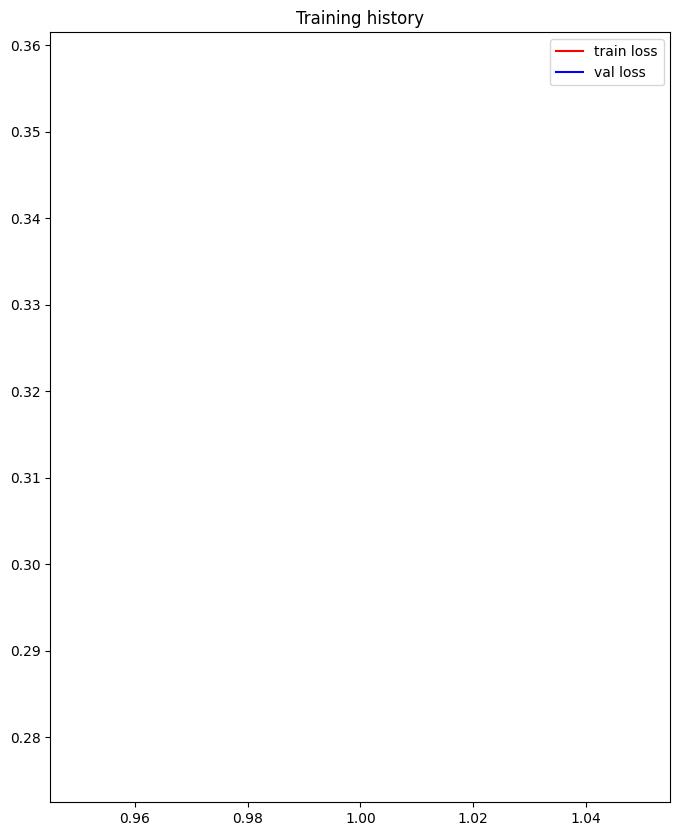

In [ ]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='val loss')
plt.title('Training history')
plt.legend()
plt.show()